# `MEDUSA`
aka. Dynamic-Prospective LCA aka. Union(premise, temporalis)

Notebook demonstrating the dynamic characterization possibilities of medusa

In [1]:
from bw_temporalis import easy_timedelta_distribution, TemporalDistribution, easy_datetime_distribution
import sys
import os
sys.path.append(os.path.realpath('../'))
from medusa.edge_extractor import *
from medusa.matrix_modifier import MatrixModifier
from medusa.medusa_lca import *
from medusa.timeline_builder import TimelineBuilder
from medusa.dynamic_characterization import DynamicCharacterization
import bw2data as bd
import bw2calc as bc
import numpy as np
import pandas as pd

In [2]:
from tests.databases import *
db_dynamic_cf_test()

100%|██████████| 4/4 [00:00<?, ?it/s]

Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]

Vacuuming database 


Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 2001.58it/s]

Vacuuming database 


Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<00:00, 2938.22it/s]

Vacuuming database 


In [3]:
demand = {('foreground', 'A'): 1}
gwp = ('GWP', 'example')

# Static LCA

In [4]:
slca = bc.LCA(demand, gwp)
slca.lci()
slca.lcia()
print(f'Static LCA score: {slca.score}')

Static LCA score: 641.0


# `MEDUSA` LCA

In [5]:
SKIPPABLE = [node.id for node in bd.Database('background_2020')] + [
    node.id for node in bd.Database('background_2024')
]

def filter_function(database_id: int) -> bool:
    return database_id in SKIPPABLE

Now we can do the graph traversal and create a timeline of edges:

In [6]:
import warnings
warnings.filterwarnings("ignore")

database_date_dict = {
            'background_2008': datetime.strptime("2008", "%Y"),
            'background_2024': datetime.strptime("2024", "%Y"),
            'foreground': "dynamic", # flag databases that should be temporally distributed with "dynamic"
        }

In [7]:
mlca = MedusaLCA(demand, gwp, filter_function, database_date_dict, max_calc=1000)

Starting graph traversal
Calculation count: 3


In [8]:
mlca.build_timeline()

All databases in database_date_dict exist as brightway project databases


,hash_producer,time_mapped_producer,date_producer,producer,producer_name,hash_consumer,time_mapped_consumer,date_consumer,consumer,consumer_name,amount,interpolation_weights
0,1999,1355,1999-01-01,1349,C,1999,1356,1999-01-01,1353,B,13.0,{'background_2008': 1}
1,1999,1356,1999-01-01,1353,B,2024,1359,2024-01-01,1354,A,2.0,{'background_2008': 1}
2,2019,1357,2019-01-01,1349,C,2019,1358,2019-01-01,1353,B,13.0,"{'background_2008': 0.312457221081451, 'backgr..."
3,2019,1358,2019-01-01,1353,B,2024,1359,2024-01-01,1354,A,2.0,"{'background_2008': 0.312457221081451, 'backgr..."
4,2024,1359,2024-01-01,1354,A,2024,-1,2024-01-01,-1,-1,1.0,{'background_2024': 1}


In [9]:
mlca.build_datapackage()

In [10]:
mlca.lci()

In [11]:
mlca.lcia()

In [12]:
print('New MEDUSA LCA Score:', mlca.score)
print('Old static LCA Score:', slca.score)

New MEDUSA LCA Score: 641.0
Old static LCA Score: 641.0


In [13]:
mlca.build_dynamic_biosphere()

In [26]:
mlca.calculate_dynamic_lci()


In [27]:
mlca.dynamic_inventory


{'CO2': {'time': array(['1988-01-01T03:36:00', '1999-01-01T00:00:00',
         '2004-01-01T03:36:00', '2008-01-01T00:00:00',
         '2008-01-01T00:00:00', '2017-12-31T10:12:00',
         '2019-01-01T00:00:00', '2022-12-31T18:10:48',
         '2024-01-01T00:00:00', '2024-01-01T00:00:00',
         '2027-12-31T20:24:00', '2033-12-31T10:12:00',
         '2043-12-31T20:24:00'], dtype='datetime64[s]'),
  'amount': array([ 81.8973306 , 312.        ,  42.9026694 , 409.48665298,
         409.48665298, 286.64065708, 312.        ,  17.        ,
         214.51334702, 214.51334702,  40.9486653 , 150.15934292,
          21.4513347 ]),
  'emitting_process': array([1352, 1355, 1350, 1351, 1352, 1352, 1357, 1359, 1349, 1350, 1352,
         1350, 1350])},
 'CO': {'time': array(['1999-01-01T00:00:00', '2006-12-31T18:10:48',
         '2008-01-01T00:00:00', '2008-01-01T00:00:00',
         '2019-01-01T00:00:00', '2022-12-31T18:10:48',
         '2024-01-01T00:00:00', '2024-01-01T00:00:00'],
        dtype=

### dynamic LCA 
Medusa allows to calculate radiative forcing [W/m2] and GWP [kg CO2eq] over fexible time horizons (TH). Default TH is 100 years.

The TH of analysis can be flexible (fixed_TH == False), which calculates the warming for the duration of TH from the timing each each emission or it can be fixed (fixed_TH), which harmonizes the duration of impact calculation to duration of TH starting from the functional unit. This means that emissions occuring later than the functional unit are counted for a shorter time (less impact) and emission occuring earlier are counted for a longer time (more impact). See more information in Levasseur 2010.

Calculate dynamic emissions for radiative forcing, flexible TH and 100 years TH (default)

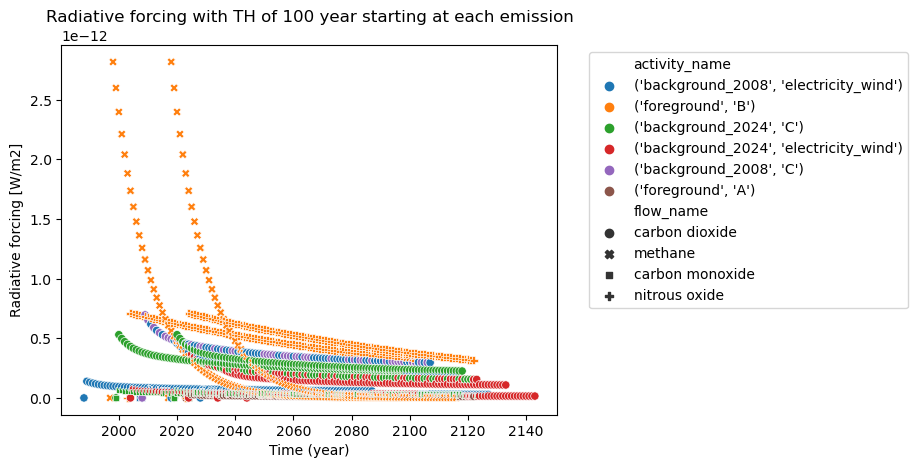

characterized dynamic score: 4.2875294464474183e-10 [radiative_forcing (100 year)]


In [15]:

mlca.characterize_dynamic_lci(type="radiative_forcing", fixed_TH = False)
mlca.plot_dynamic_characterized_inventory()
print(f"characterized dynamic score: {mlca.characterized_dynamic_score} [{mlca.type_of_method} ({mlca.TH} {mlca.temporal_grouping})]")

In [16]:
# show characterized inventory 
mlca.characterized_inventory

,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,1988-01-01 03:36:00,0.000000e+00,1345,carbon dioxide,1352,"(background_2008, electricity_wind)",0.000000e+00
1,1988-12-31 09:25:12,1.392583e-13,1345,carbon dioxide,1352,"(background_2008, electricity_wind)",1.392583e-13
2,1989-12-31 15:14:24,1.307248e-13,1345,carbon dioxide,1352,"(background_2008, electricity_wind)",2.699832e-13
3,1990-12-31 21:03:36,1.237484e-13,1345,carbon dioxide,1352,"(background_2008, electricity_wind)",3.937316e-13
4,1992-01-01 02:52:48,1.180115e-13,1345,carbon dioxide,1352,"(background_2008, electricity_wind)",5.117430e-13
...,...,...,...,...,...,...,...
1295,2138-12-31 21:18:00,1.566206e-14,1345,carbon dioxide,1350,"(background_2024, electricity_wind)",2.296864e-10
1296,2140-01-01 03:07:12,1.562353e-14,1345,carbon dioxide,1350,"(background_2024, electricity_wind)",2.297020e-10
1297,2140-12-31 08:56:24,1.558563e-14,1345,carbon dioxide,1350,"(background_2024, electricity_wind)",2.297176e-10
1298,2141-12-31 14:45:36,1.554834e-14,1345,carbon dioxide,1350,"(background_2024, electricity_wind)",2.297331e-10


Calculate dynamic emissions for radiative forcing, fixed TH and 100 years TH (default) -> forcing is cut off at timing of FU + TH

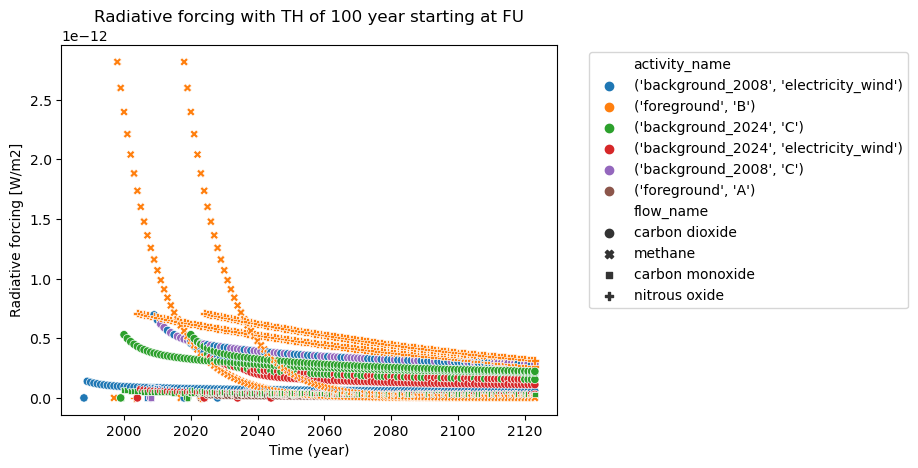

characterized dynamic score: 4.5617437251114417e-10 [radiative_forcing (100)]


In [17]:
mlca.characterize_dynamic_lci(type="radiative_forcing", fixed_TH = True)
mlca.plot_dynamic_characterized_inventory()
print(f"characterized dynamic score: {mlca.characterized_dynamic_score} [{mlca.type_of_method} ({mlca.TH})]")


In [18]:
mlca.characterized_inventory

,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,1988-01-01 03:36:00,0.000000e+00,1345,carbon dioxide,1352,"(background_2008, electricity_wind)",0.000000e+00
1,1988-12-31 09:25:12,1.392583e-13,1345,carbon dioxide,1352,"(background_2008, electricity_wind)",1.392583e-13
2,1989-12-31 15:14:24,1.307248e-13,1345,carbon dioxide,1352,"(background_2008, electricity_wind)",2.699832e-13
3,1990-12-31 21:03:36,1.237484e-13,1345,carbon dioxide,1352,"(background_2008, electricity_wind)",3.937316e-13
4,1992-01-01 02:52:48,1.180115e-13,1345,carbon dioxide,1352,"(background_2008, electricity_wind)",5.117430e-13
...,...,...,...,...,...,...,...
1623,2123-01-01 01:40:48,1.180465e-16,1346,methane,1356,"(foreground, B)",7.274671e-11
1390,2123-01-01 05:16:48,2.230643e-13,1345,carbon dioxide,1357,"(background_2024, C)",2.480304e-10
1624,2123-01-01 05:16:48,5.922811e-16,1346,methane,1358,"(foreground, B)",7.274730e-11
2504,2123-01-01 05:16:48,2.907304e-14,1347,carbon monoxide,1357,"(background_2024, C)",3.247884e-11


We can also calculate dynamic emissions for GWP, flexible TH and 100 years TH (default)

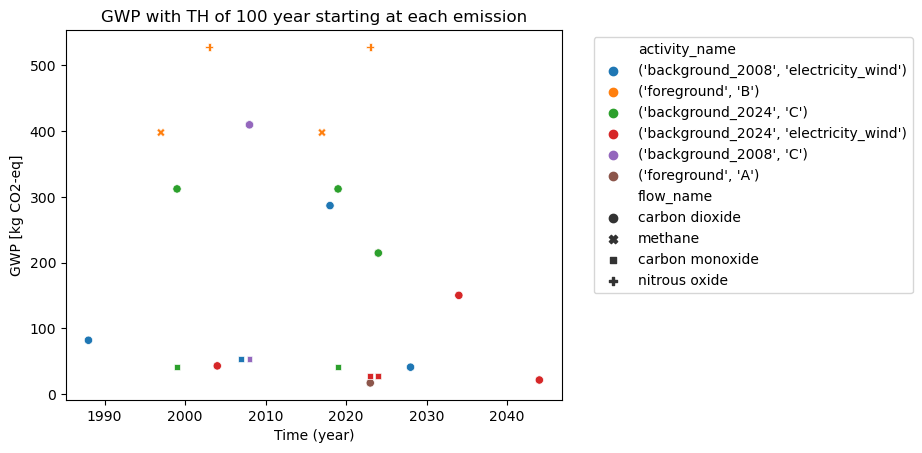

characterized dynamic score: 4689.716824792423 [GWP (100)]


In [29]:
mlca.characterize_dynamic_lci(type="GWP", fixed_TH = False, TH=100)
mlca.plot_dynamic_characterized_inventory()
print(f"characterized dynamic score: {mlca.characterized_dynamic_score} [{mlca.type_of_method} ({mlca.TH})]")

In [30]:
mlca.characterized_dynamic_score

4689.716824792423

With fixed TH of 100 years

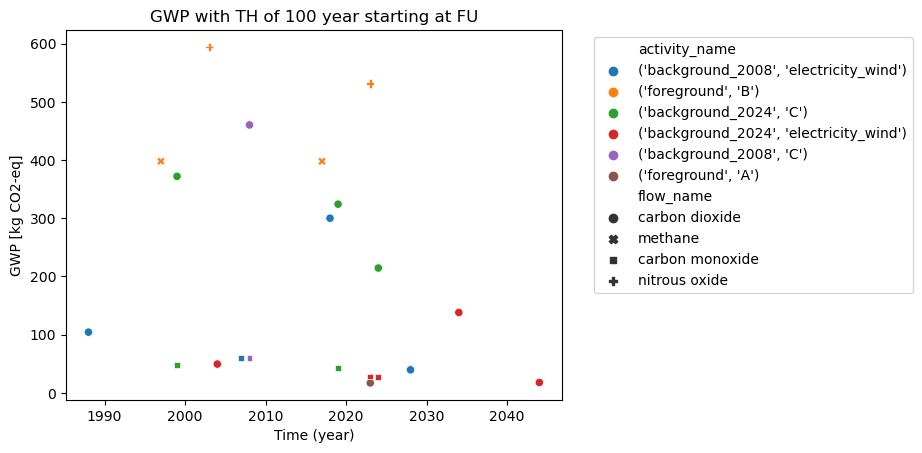

In [31]:
mlca.characterize_dynamic_lci(type="GWP", fixed_TH = True)
mlca.plot_dynamic_characterized_inventory()

In [32]:
mlca.characterized_dynamic_score

4989.653497487356

additionally, we can vary the TH: e.g. to 20 years


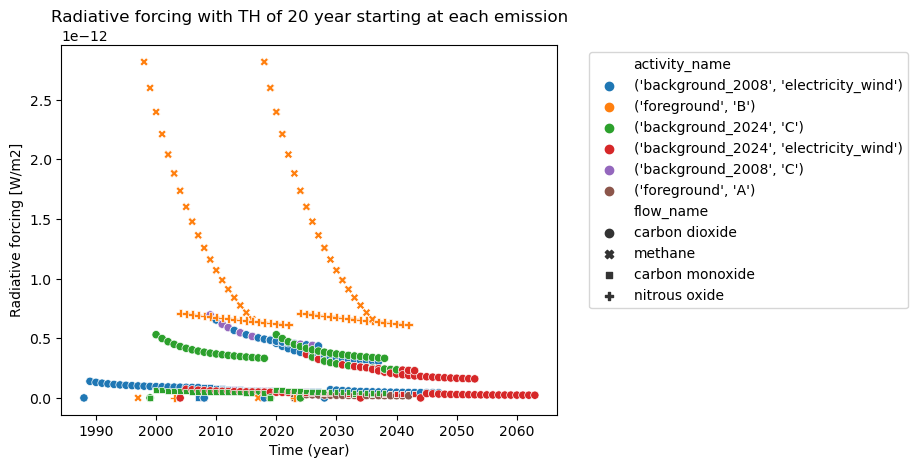

characterized dynamic score: 1.5029247085066814e-10 [radiative_forcing (20)]


In [21]:
mlca.characterize_dynamic_lci(type="radiative_forcing", fixed_TH = False, TH=20)
mlca.plot_dynamic_characterized_inventory()
print(f"characterized dynamic score: {mlca.characterized_dynamic_score} [{mlca.type_of_method} ({mlca.TH})]")

In [22]:
mlca.dynamic_inventory_characterizer.levasseur_dcfs.keys() 
# available dynamic characterization factors for GHGs, only first 4 ones are currently used but all would be there

dict_keys(['carbon dioxide', 'methane', 'nitrous oxide', 'carbon monoxide', 'CFC-11', 'CFC-12', 'CFC-13', 'CFC-113', 'CFC-114', 'CFC-115', 'Halon-1201', 'Halon-1202', 'Halon-1211', 'Halon-1301', 'Halon-2301', 'Halon-2311', 'Halon-2401', 'Halon-2402', 'Carbon tetrachloride (CFC-10)', 'Methyl bromide (Halon 1001)', 'Methylene bromide', 'Methyl chloroform (trichloroethane)', '1,2-dichloroethane', 'Chloroform', 'HCFC-21', 'HCFC-22', 'HCFC-122', 'HCFC-122a', 'HCFC-123', 'HCFC-124', 'HCFC-132c', 'HCFC-141b', 'HCFC-142b', 'HCFC-225ca', 'HCFC-225cb', 'E-1-chloro-3,3,3-trifluoroprop-1-ene', 'HFC-23', 'HFC-32', 'HFC-41', 'HFC-125', 'HFC-134', 'HFC-134a', 'HFC-143', 'HFC-143a', 'HFC-152', 'HFC-152a', 'HFC-161', 'HFC-227ca', 'HFC-227ea', 'HFC-236cb', 'HFC-236ea', 'HFC-236fa (HCFC-236fa)', 'HFC-245ca', 'HFC-245cb', 'HFC-245ea', 'HFC-245eb', 'HFC-245fa', 'HFC-272ca', 'HFC-365mfc', 'HFC-43-10mee', 'HFC-1132a', 'HFC-1141', 'Z-HFC-1225ye', 'E-HFC-1225ye', 'Z-HFC-1234ze', 'HFC-1234yf', 'E-HFC-1234ze', '